# Importing Libraries

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.patches as patches
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', 150)

# modeling libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

# utilities
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, classification_report, auc
from sklearn.preprocessing import StandardScaler
#from sklearn.grid_search import GridSearchCV



from collections import OrderedDict

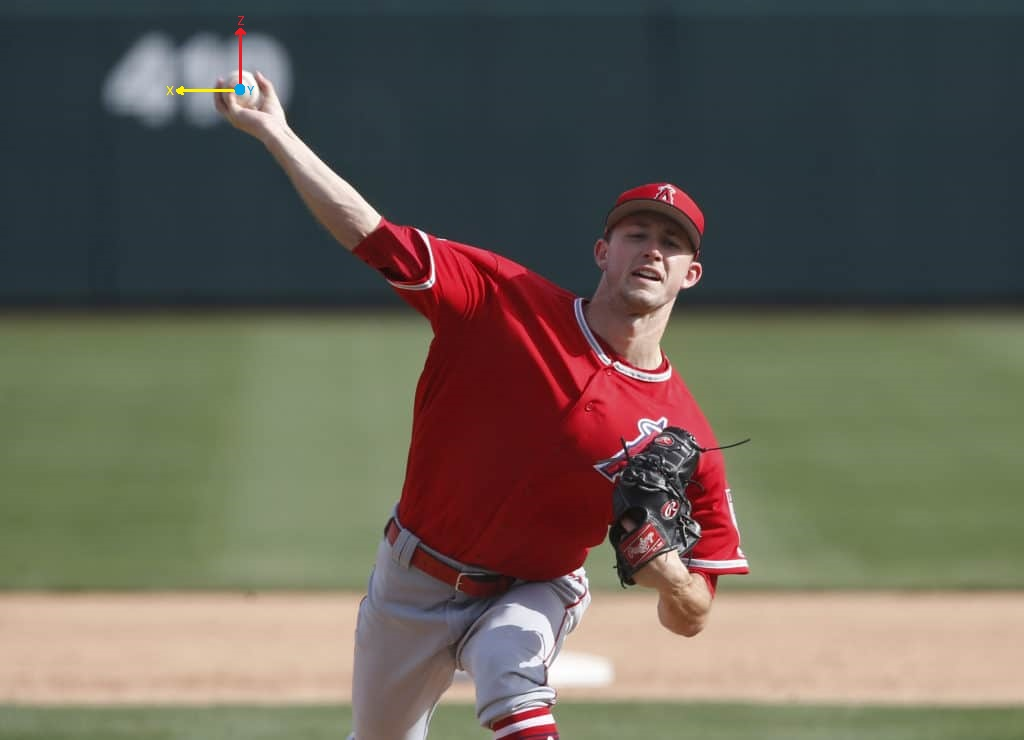

In [2]:
from IPython.display import Image
Image(filename='pitch_pic.jpg') 

To begin familiarizing with some of the features, we will first look at the coordinate system used in the dataset/pfx. The z-direction will be associated to the vertical distance, the x-direction will be associated to the horizontal distance, and the y-direction will be associated towards the catcher/batter. Note that the point of origin changes based on which feature we will be looking at like release position versus the position the ball crosses the plate. 

In [3]:
df = pd.read_csv('savant_data.csv')
print(df.shape)
df.head()

(40000, 89)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,FF,2019-06-30,101.3,0.5509,6.1836,Aroldis Chapman,543877,547973,strikeout,swinging_strike,NaN,NaN,NaN,NaN,13.0,Christian Vazquez strikes out swinging.,R,R,L,BOS,NYY,S,2.0,NaN,0,2,2019,1.1841,0.9995,-0.1572,1.5416,NaN,593523.0,NaN,2,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183411,-4.8611,-147.1613,-10.0811,18.5249,36.4048,-15.2666,3.5,1.7,NaN,NaN,NaN,NaN,2541.0,6.6473,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,53.8529,NaN,NaN,0.0,1.0,0.0,0.0,NaN,92,3,4-Seam Fastball,8,12,8,12,12,8,8,12,NaN,NaN
1,CH,2019-06-30,87.2,0.5008,6.3708,Aroldis Chapman,543877,547973,NaN,foul,NaN,NaN,NaN,NaN,5.0,NaN,R,R,L,BOS,NYY,S,NaN,NaN,0,1,2019,-0.8553,0.1403,-0.1097,2.8397,NaN,593523.0,NaN,2,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183325,0.2824,-126.9700,-2.5902,-9.2334,27.3368,-30.3440,3.5,1.7,NaN,NaN,NaN,NaN,2812.0,6.2259,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,54.2743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,2,Changeup,8,12,8,12,12,8,8,12,NaN,NaN
2,FF,2019-06-30,99.4,0.6354,6.2711,Aroldis Chapman,543877,547973,NaN,foul,NaN,NaN,NaN,NaN,5.0,NaN,R,R,L,BOS,NYY,S,NaN,NaN,0,0,2019,0.0966,1.5501,0.0167,2.6030,NaN,593523.0,NaN,2,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183244,-1.9282,-144.5943,-8.2683,1.8397,36.6497,-8.6289,3.5,1.7,NaN,NaN,NaN,NaN,2586.0,6.4608,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,54.0394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,1,4-Seam Fastball,8,12,8,12,12,8,8,12,NaN,NaN
3,FF,2019-06-30,100.0,0.5805,6.2837,Aroldis Chapman,656308,547973,strikeout,foul_tip,NaN,NaN,NaN,NaN,5.0,Michael Chavis strikes out on a foul tip.,R,R,L,BOS,NYY,S,2.0,NaN,0,2,2019,1.0118,1.3386,0.1241,2.3864,NaN,593523.0,NaN,1,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183144,-3.7012,-145.4269,-8.6002,15.3883,35.3925,-11.1183,3.5,1.7,NaN,NaN,NaN,NaN,2596.0,6.7012,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,53.7990,NaN,NaN,0.0,1.0,0.0,0.0,NaN,91,3,4-Seam Fastball,8,12,8,12,12,8,8,12,NaN,NaN
4,FF,2019-06-30,98.6,0.5832,6.2344,Aroldis Chapman,656308,547973,NaN,foul,NaN,NaN,NaN,NaN,5.0,NaN,R,R,L,BOS,NYY,S,NaN,NaN,0,1,2019,0.2288,1.4388,-0.1114,2.2780,NaN,593523.0,NaN,1,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183100,-2.4475,-143.4481,-8.7536,3.7733,33.8462,-10.2072,3.5,1.7,NaN,NaN,NaN,NaN,2519.0,6.7412,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,53.7590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91,2,4-Seam Fastball,8,12,8,12,12,8,8,12,NaN,NaN


# Cleaning

There are many outcomes that can occur during a pitch so for simplicity we will group some of the less occuring events into their corresponding ones.

In [4]:
# Cleaning for events column by combining similar events to reduce noise in eda and modeling process
# Notes: Triples may need to be labeled into something else due to lack of frequency

df['events'].replace(['fielders_choice', 'fielders_choice_out', 'double_play', 'grounded_into_double_play'], 'field_out', inplace=True)
df['events'].replace('hit_by_pitch', 'walk', inplace=True)
df['events'].replace(['force_out', 'sac_fly', 'sac_bunt'], 'field_out', inplace=True)
df['events'].replace('strikeout_double_play', 'strikeout', inplace=True)
df = df[~df['events'].isin(['caught_stealing_2b', 'field_error', 'catcher_interf', 'pickoff_1b', 'caught_stealing_home', 'pickoff_caught_stealing_2b', 'pickoff_2b'])]


In [5]:
# Cleaning for description column for same reason above

df['description'].replace(['foul_tip', 'foul_bunt', 'bunt_foul_tip'], 'foul', inplace=True)
df['description'].replace('swinging_strike_blocked', 'swinging_strike', inplace=True)
df['description'].replace('missed_bunt', 'called_strike', inplace=True)
df['description'].replace(['foul_tip', 'foul_bunt', 'bunt_foul_tip'], 'foul', inplace=True)
df['description'].replace('blocked_ball', 'ball', inplace=True)
df = df[~df['description'].isin(['pitchout'])]

In [6]:
# Dropping columns that aren't related to the likelihood of throwing a strike
df = df.drop(['game_date', 'spin_dir', 'spin_rate_deprecated', 
              'break_angle_deprecated', 'break_length_deprecated', 
              'game_type', 'game_year', 'on_3b', 'on_2b', 'on_1b',
              'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2',
              'umpire', 'sv_id', 'fielder_2.1', 'fielder_3',
              'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 
              'fielder_8', 'fielder_9', 'pitch_type', 'des', 'home_team', 
              'away_team','launch_speed', 'launch_angle', 'launch_speed_angle', 'hit_distance_sc',
              'pitcher.1', 'if_fielding_alignment', 'of_fielding_alignment', 
              'woba_value', 'woba_denom', 'babip_value', 'iso_value',
              'pitcher', 'batter','hit_location','bb_type', 'hc_y', 'hc_x',
              'estimated_ba_using_speedangle','estimated_woba_using_speedangle','type',
              'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score'], axis=1)

# Reordering columns to make it easier to read
cols = df.columns.tolist()
cols = ['player_name','balls','strikes','events', 'description', 'outs_when_up', 'zone',
        'stand', 'p_throws', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'inning',
        'inning_topbot', 'release_speed', 'release_pos_x', 'release_pos_z', 'vx0', 'vy0', 'vz0',
        'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'effective_speed', 'release_spin_rate', 
        'release_extension', 'release_pos_y', 'at_bat_number', 'pitch_number',
        'pitch_name', 'home_score', 'away_score', 'bat_score', 'fld_score', 'game_pk']
df = df[cols]
df.head()

,player_name,balls,strikes,events,description,outs_when_up,zone,stand,p_throws,pfx_x,pfx_z,plate_x,plate_z,inning,inning_topbot,release_speed,release_pos_x,release_pos_z,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,effective_speed,release_spin_rate,release_extension,release_pos_y,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,game_pk
0,Aroldis Chapman,0,2,strikeout,swinging_strike,2,13.0,R,L,1.1841,0.9995,-0.1572,1.5416,9,Bot,101.3,0.5509,6.1836,-4.8611,-147.1613,-10.0811,18.5249,36.4048,-15.2666,3.5,1.7,NaN,2541.0,6.6473,53.8529,92,3,4-Seam Fastball,8,12,8,12,565068
1,Aroldis Chapman,0,1,NaN,foul,2,5.0,R,L,-0.8553,0.1403,-0.1097,2.8397,9,Bot,87.2,0.5008,6.3708,0.2824,-126.9700,-2.5902,-9.2334,27.3368,-30.3440,3.5,1.7,NaN,2812.0,6.2259,54.2743,92,2,Changeup,8,12,8,12,565068
2,Aroldis Chapman,0,0,NaN,foul,2,5.0,R,L,0.0966,1.5501,0.0167,2.6030,9,Bot,99.4,0.6354,6.2711,-1.9282,-144.5943,-8.2683,1.8397,36.6497,-8.6289,3.5,1.7,NaN,2586.0,6.4608,54.0394,92,1,4-Seam Fastball,8,12,8,12,565068
3,Aroldis Chapman,0,2,strikeout,foul,1,5.0,R,L,1.0118,1.3386,0.1241,2.3864,9,Bot,100.0,0.5805,6.2837,-3.7012,-145.4269,-8.6002,15.3883,35.3925,-11.1183,3.5,1.7,NaN,2596.0,6.7012,53.7990,91,3,4-Seam Fastball,8,12,8,12,565068
4,Aroldis Chapman,0,1,NaN,foul,1,5.0,R,L,0.2288,1.4388,-0.1114,2.2780,9,Bot,98.6,0.5832,6.2344,-2.4475,-143.4481,-8.7536,3.7733,33.8462,-10.2072,3.5,1.7,NaN,2519.0,6.7412,53.7590,91,2,4-Seam Fastball,8,12,8,12,565068


In [7]:
# We will drop row 987 because mose of the column entries are null and can't be salvaged
df = df[df['release_speed'].notnull()]

# Dropping rows with null effective speed values. Subject to change in future iterations
df = df[df['effective_speed'].notnull()]

# dropping rows where pitch type is unknown (note: consider doing the reverse of what we did for release_spin_rate)
# dropping knuckle ball, forkball, and euphus pitches due to how rare they are
df = df[df['pitch_name'].notnull()]
df = df[~df['pitch_name'].isin(['Eephus', 'Forkball', 'Knuckle Ball'])]

# imputing release_spin_rate with mean values grouped by pitch_name (i.e. curve balls spin the fastest compared to other pitches)
df['release_spin_rate'] = df['release_spin_rate'].fillna(df.groupby('pitch_name')['release_spin_rate'].transform('mean'))

# Replacing null values with 'nothing' to represent when the batter remains at bat after the result of the at bat attempt
df['events'] = df['events'].fillna('no_event')

# defining response variable that determines if the batter got on base or not (1 for strikes/outs 0 for balls or hits on base)
df['strike_result'] = df['description'].isin(['hit_into_play', 'called_strike', 'swinging_strike', 'foul']) * 1

# confirming that there are no more null values
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

# Exploratory Data Analysis

First we'll look at the statistics involved when looking at the best and worst pitcher based on our metric the strike_result. Remember we'll only be looking at starting pitchers so we have to filter out relief pitchers and closers to find the best and worst starting pitchers.

In [28]:
# We will filter out any pitchers that haven't pitched in the first inning before
starting_pitchers_names = df.player_name.loc[df['inning']==1].unique()
starting_pitchers = (df.loc[df.player_name.isin(starting_pitchers_names)]
                        .groupby('player_name')
                        .agg({'release_speed':'mean',
                              'strike_result':'mean',
                              'at_bat_number':'count',
                              'pitch_name':lambda x:x.value_counts().index[0],
                              'release_pos_x':'mean',
                              'release_pos_y':'mean',
                              'release_pos_z':'mean',
                              'release_extension':'mean',
                              'pfx_x':'mean',
                              'pfx_z':'mean'})
                        .sort_values(by='strike_result', ascending=False))
best_pitchers = starting_pitchers.head(1)
worst_pitchers = starting_pitchers.tail(1)
pd.concat([best_pitchers, worst_pitchers], axis='rows')



,release_speed,strike_result,at_bat_number,pitch_name,release_pos_x,release_pos_y,release_pos_z,release_extension,pfx_x,pfx_z
player_name,,,,,,,,,,
Max Scherzer,89.140670,0.708134,209,4-Seam Fastball,-3.444684,54.670836,5.340946,5.828665,-0.463185,0.600982
Mike Clevinger,89.707692,0.442308,52,4-Seam Fastball,-1.525148,54.055900,5.531917,6.443596,0.031679,0.632471


As seen above, Max Scherzer is our 'best' pitcher, and Mike Clevinger our 'worst'.

In [11]:
# filtering out non-starters and sorting events into chronological order
game_stats = (df.loc[df.player_name.isin(starting_pitchers_names)]
                   .sort_values(['game_pk','inning', 'inning_topbot', 'outs_when_up', 'at_bat_number', 'pitch_number'],
                         ascending=[False, True, False, True, True, True]))

# aggregating performance of each pitcher into games played into number of innings played and how many points given
season_stats = (game_stats.groupby(['game_pk', 'player_name'])
                          .agg({'bat_score':lambda x: x.max() - x.min(),
                                'inning': lambda x: x.max() - x.min() + 1}))

# creating a feature called ERA (Earned Run Average) representing the number of runs given for the season so far.
season_stats['ERA'] = round(season_stats['bat_score']*9 / season_stats['inning'], 2)
season_stats = season_stats.groupby('player_name').agg({'ERA':'mean', 'inning':'sum'}).sort_values('ERA').head()


low_era_pitchers = (df.loc[df.player_name.isin(season_stats.index)]
                        .groupby('player_name')
                        .agg({'release_speed':'mean',
                              'strike_result':'mean',
                              'at_bat_number':'count',
                              'pitch_name':lambda x:x.value_counts().index[0],
                              'release_pos_x':'mean',
                              'release_pos_y':'mean',
                              'release_pos_z':'mean',
                              'release_extension':'mean',
                              'pfx_x':'mean',
                              'pfx_z':'mean'})
                        .sort_values(by='strike_result', ascending=False))

low_era_pitchers


,release_speed,strike_result,at_bat_number,pitch_name,release_pos_x,release_pos_y,release_pos_z,release_extension,pfx_x,pfx_z
player_name,,,,,,,,,,
Daniel Mengden,86.002151,0.645161,93,4-Seam Fastball,-1.611784,54.275319,5.885624,6.224161,-0.150159,0.733908
John Means,87.236145,0.614458,83,4-Seam Fastball,0.680183,54.638670,6.519657,5.860867,0.578743,1.417798
Chad Green,94.703571,0.607143,28,4-Seam Fastball,-2.101182,54.310464,5.913082,6.189000,-0.452057,1.132879
Matt Carasiti,94.151111,0.555556,45,Sinker,-2.064160,54.666064,6.035233,5.833333,-0.977502,0.820591
Aaron Civale,86.677907,0.511628,86,Sinker,-1.305345,55.185731,6.018490,5.313802,-0.232423,0.449184


We will now compare 3 pitchers with very different skill levels. Max Scherzer who has the best strike rate, Marcus Stroman who is the highest paid pitcher on the Blue Jays, and Mike Clevinger who is worst performing pitcher this year. By grouping the different pitches that these pitchers can use, we can discover subtle differences between them.

In [29]:
player_comparison = (df[df.player_name.isin(['Max Scherzer', 'Mike Clevinger', 'Marcus Stroman'])]
 .groupby(['pitch_name','player_name'])
 .agg({'release_speed':'mean',          
      'at_bat_number':'count',
      'pitch_name':lambda x:x.value_counts().index[0],
       'vx0':'mean',
       'vy0':'mean',
       'vz0':'mean',
       'ax':'mean',
       'ay':'mean',
      'release_pos_x':'mean',
      'release_pos_y':'mean',
      'release_pos_z':'mean',
      'release_extension':'mean',
      'release_spin_rate':'mean',
      'pfx_x':'mean',
      'pfx_z':'mean',
      'strike_result':'mean'})
)
player_comparison

release_speed  at_bat_number       pitch_name  \
pitch_name      player_name                                                     
2-Seam Fastball Marcus Stroman      92.662500             40  2-Seam Fastball   
4-Seam Fastball Marcus Stroman      93.085714              7  4-Seam Fastball   
                Max Scherzer        95.295455             88  4-Seam Fastball   
                Mike Clevinger      96.303704             27  4-Seam Fastball   
Changeup        Marcus Stroman      87.600000              3         Changeup   
                Max Scherzer        83.939394             33         Changeup   
                Mike Clevinger      90.000000              8         Changeup   
Curveball       Marcus Stroman      73.600000              2        Curveball   
                Max Scherzer        78.418750             16        Curveball   
                Mike Clevinger      77.788889              9        Curveball   
Cutter          Marcus Stroman      91.356000             50           Cutter   
                Max Scherzer        89.911765             17           Cutter   
Slider          Marcus Stroman      86.560294             68           Slider   
                Max Scherzer        85.294545             55           Slider   
                Mike Clevinger      80.562500              8           Slider   

                                      vx0         vy0       vz0         ax  \
pitch_name      player_name                                                  
2-Seam Fastball Marcus Stroman   4.983645 -134.841375 -3.036985 -12.799878   
4-Seam Fastball Marcus Stroman   4.994429 -135.464014 -2.810429  -4.630743   
                Max Scherzer    11.162019 -138.214139 -4.728298 -14.924670   
                Mike Clevinger   4.045226 -140.220889 -5.986300  -6.778993   
Changeup        Marcus Stroman   6.422133 -127.414767 -4.200467 -11.496633   
                Max Scherzer     9.068003 -121.845679 -2.803448 -14.309473   
                Mike Clevinger   5.507850 -131.048587 -5.709325 -13.030487   
Curveball       Marcus Stroman   2.444750 -106.927200 -1.494700   8.536800   
                Max Scherzer     4.471944 -114.077500  0.748044   7.170719   
                Mike Clevinger  -0.632089 -113.185689  1.228133   8.352656   
Cutter          Marcus Stroman   5.143366 -132.916132 -1.918036  -0.327896   
                Max Scherzer    10.041453 -130.517847 -4.484559  -1.294006   
Slider          Marcus Stroman   3.444304 -125.945756 -1.957790   7.148404   
                Max Scherzer     8.651307 -123.850404 -1.478180   1.413389   
                Mike Clevinger  -0.439412 -117.269825 -0.441037  14.707512   

                                       ay  release_pos_x  release_pos_y  \
pitch_name      player_name                                               
2-Seam Fastball Marcus Stroman  25.760488      -1.400732      54.804125   
4-Seam Fastball Marcus Stroman  26.453929      -1.206557      54.679386   
                Max Scherzer    29.418499      -3.393165      54.615100   
                Mike Clevinger  30.679911      -1.624515      53.804385   
Changeup        Marcus Stroman  23.084800      -1.394967      54.758800   
                Max Scherzer    22.829933      -3.469291      54.626206   
                Mike Clevinger  24.670412      -1.454425      53.595487   
Curveball       Marcus Stroman  17.656050      -1.531800      56.159600   
                Max Scherzer    19.181556      -3.344212      54.949612   
                Mike Clevinger  19.815867      -1.253789      54.758756   
Cutter          Marcus Stroman  25.126082      -1.411634      54.932766   
                Max Scherzer    24.485988      -3.466041      54.716247   
Slider          Marcus Stroman  23.120596      -1.446850      55.100301   
                Max Scherzer    24.174227      -3.534978      54.691658   
                Mike Clevinger  21.951837      -1.565788      54.574463   

                                release_pos_z  rele

Speed doesn't seem to be the most important factor that determines a strike as generally assumed. Mike Clevinger's 4-seam fastball release speed seems to be the fastest, but simultaneously the worst performaning amongst the two other pitchers. One important difference observed is the vx0, and ax0 features are significantly greater for Max Scherzer compared to the other two pitchers. It is possible that a high vx0, and ax0 attribute to a higher strike chance. 

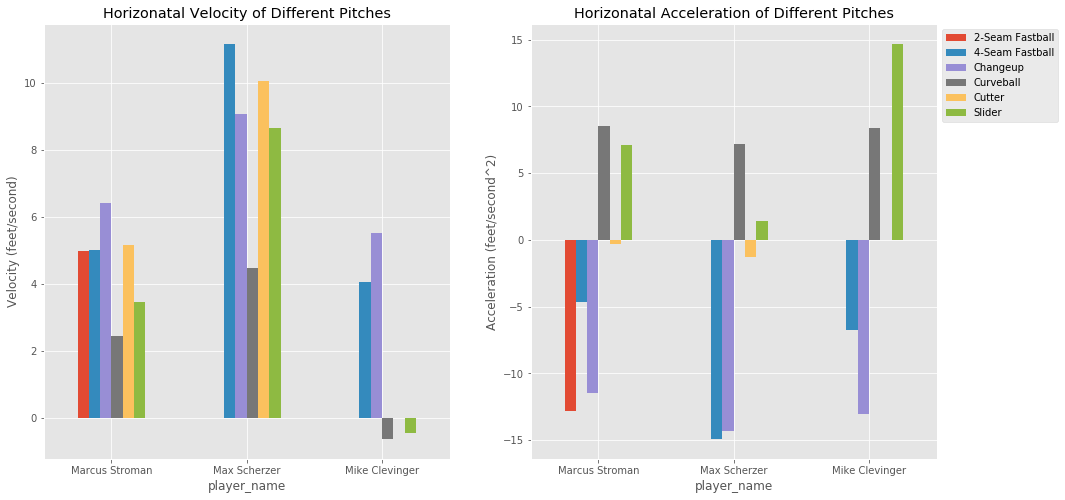

In [32]:
fig3, (ax3, ax4) = plt.subplots(1,2, figsize=(16,8))

_ = player_comparison['vx0'].unstack(level=0).plot(kind='bar', rot=0, ax=ax3, legend=False)
_ = ax3.set_title('Horizonatal Velocity of Different Pitches')
_ = ax3.set_ylabel('Velocity (feet/second)')

_ = player_comparison['ax'].unstack(level=0).plot(kind='bar', rot=0, ax=ax4)
_ = ax4.set_title('Horizonatal Acceleration of Different Pitches')
_ = ax4.set_ylabel('Acceleration (feet/second^2)')
_ = plt.legend(bbox_to_anchor=(1,1), loc='upper left')

One intersting oberservation above is that Max's 4-seam fastball and changeup are the most identical in terms of vx0 and particularly ax0. Given that Max's success rate for the changeup is the highest at a 75.7% mark, this may be a large contributing factor. What this would mean is that Max is successfully tricking batters into thinking he's about to throw a 4-seam fastball when he's throwing a changeup or vice versa, based on the way he swings out his arm.

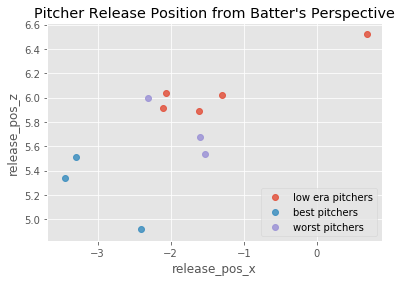

In [14]:

_ = sns.regplot('release_pos_x', 'release_pos_z', data=low_era_pitchers, fit_reg=False, label='low era pitchers')
_ = sns.regplot('release_pos_x', 'release_pos_z', data=best_pitchers, fit_reg=False, label='best pitchers')
_ = sns.regplot('release_pos_x', 'release_pos_z', data=worst_pitchers, fit_reg=False, label='worst pitchers')
_ = plt.title('Pitcher Release Position from Batter\'s Perspective')
_ = plt.legend(loc='lower right')

For ease of understanding, imagine the pitcher standing where x-axis equals zero, and the point of release is where the dot lies on the plot. The difference in the horizonatal release points between the good and bad pitchers is a really interesting pattern. From this observation we can hypothesize that pitchers who release the ball further from their bodies have higher success rate of striking out batters. Height and arm length may be a big contributing factor in release_pos_x as well.

Note: negative values of release_pos_x represent right handed pitchers and postive x values correspond to left handers

Z:\Users\Don\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


''

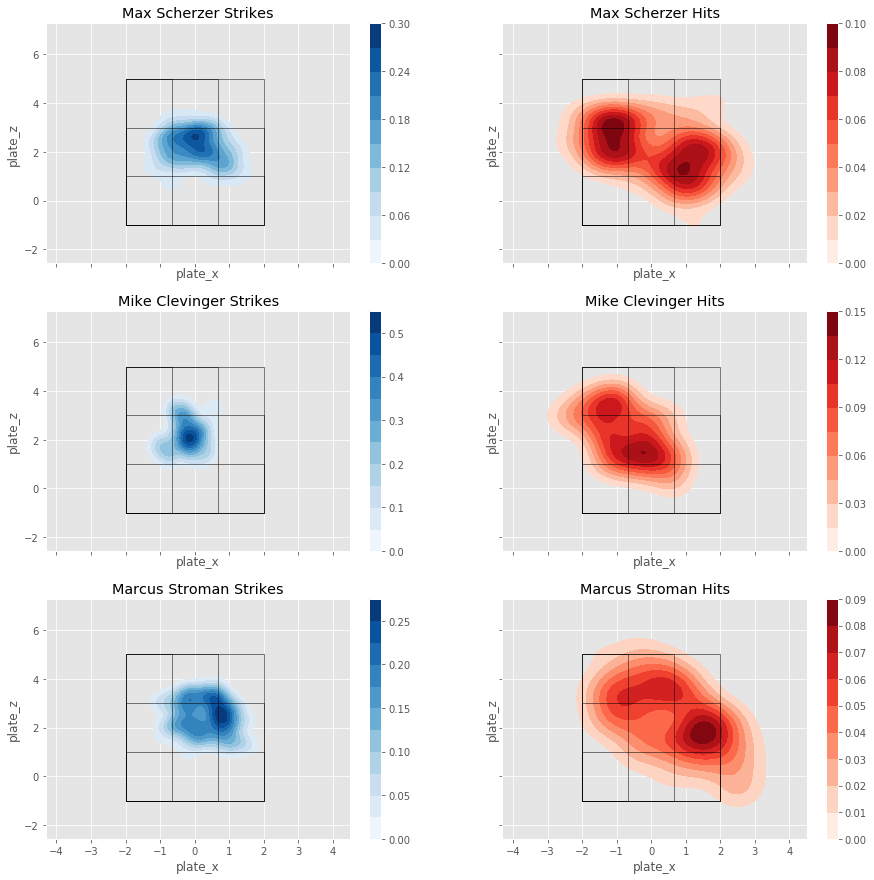

In [33]:
scherzer_strikes = df[(df['player_name']=='Max Scherzer')  & (df.strike_result==1)]
clevinger_strikes = df[(df['player_name']=='Mike Clevinger')  & (df.strike_result==1)]
stroman_strikes = df[(df['player_name']=='Marcus Stroman')  & (df.strike_result==1)]
scherzer_hits = df[(df['player_name']=='Max Scherzer') & (df.strike_result==0)]
clevinger_hits = df[(df['player_name']=='Mike Clevinger') & (df.strike_result==0)]
stroman_hits = df[(df['player_name']=='Marcus Stroman') & (df.strike_result==0) ]


fig, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(15,15))

for i in range(0,3):
    for j in range(0,2):
        ax[i,j].add_patch(patches.Rectangle((-2, -1), 4, 6, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), 4, 4, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), 4, 2, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), (4/3), 6, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), (8/3), 6, fill=False, edgecolor='black'))

sns.kdeplot(scherzer_strikes['plate_x'] , scherzer_strikes['plate_z'], cmap="Blues", shade=True, shade_lowest=False, ax=ax[0,0], cbar=True).set_title('Max Scherzer Strikes')
sns.kdeplot(clevinger_strikes['plate_x'] , clevinger_strikes['plate_z'], cmap="Blues", shade=True, shade_lowest=False, ax=ax[1,0], cbar=True).set_title('Mike Clevinger Strikes')
sns.kdeplot(civale_strikes['plate_x'] , stroman_strikes['plate_z'], cmap="Blues", shade=True, shade_lowest=False, ax=ax[2,0], cbar=True).set_title('Marcus Stroman Strikes')

sns.kdeplot(scherzer_hits['plate_x'] , scherzer_hits['plate_z'], cmap="Reds", shade=True, shade_lowest=False, ax=ax[0,1], cbar=True).set_title('Max Scherzer Hits')
sns.kdeplot(clevinger_hits['plate_x'] , clevinger_hits['plate_z'], cmap="Reds", shade=True, shade_lowest=False, ax=ax[1,1], cbar=True).set_title('Mike Clevinger Hits')
sns.kdeplot(civale_hits['plate_x'] , stroman_hits['plate_z'], cmap="Reds", shade=True, shade_lowest=False, ax=ax[2,1], cbar=True).set_title('Marcus Stroman Hits')
;

Max and Marcus seems to have a larger distribution that spreads across zones 4,5,6 whereas the worst pitcher(Mike) has a smaller distribution concentrated around zone 5. This may be a major contributing factor towards a pitcher's success.

There are a few interesting hypothesis that can be drawn from the two graphs seen above:          
    1) higher release_pos_x (aka greater height/longer arms) is directly related to the likelihood of throwing a strike     
    2) A more varied toolbox of different pitches can result in more strikes     
    3) The more similar the fastball and changeup pitches look (in terms of vx0, ax0), the more successful they can be at striking batters out          
    4) The more zones the pitcher can pitch to can lead to a higher chance to striking the batter out

# More Processing

In [16]:
df = df.drop(['balls', 'strikes', 'home_score', 'away_score', 'bat_score',
              'fld_score', 'game_pk'], axis='columns')

In [17]:
num_cols = df.columns[df.dtypes  != object]
df_num = df[num_cols]

X = df_num.drop('strike_result', axis='columns')
y = df_num['strike_result']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [18]:
#X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
strings = df.columns[df.dtypes=='object']
df_str = (pd.get_dummies(df[strings].drop(['player_name', 'events', 'description'], axis='columns'))
            .drop(['stand_L', 'p_throws_L', 'inning_topbot_Bot', 'pitch_name_Knuckle Curve'], axis='columns'))
df_all = pd.concat([df_num, df_str], axis='columns')

X2 = df_all.drop('strike_result', axis='columns')
y2 = df_all['strike_result']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.33, random_state=42)

# Modeling

We will exploring two different modeling algorithms for the baseball analysis. One will be logistic regression to interpret the results and identify the most important features in determing a successful pitcher. The second will be random forest to see how far we can push the predictive power and predict strikes and hits.

In [36]:
# Logistic Regression
print('logistic regression performance')
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
print(classification_report(y_test, model_lr.predict(X_test)))

print('\n')
print('random forest performance')
# Random Forest
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
print(classification_report(y_test, model_rf.predict(X_test)))

logistic regression performance
             precision    recall  f1-score   support

          0       0.68      0.82      0.74      4969
          1       0.84      0.71      0.77      6728

avg / total       0.77      0.76      0.76     11697



random forest performance
             precision    recall  f1-score   support

          0       0.73      0.75      0.74      4969
          1       0.81      0.79      0.80      6728

avg / total       0.78      0.77      0.78     11697



# Hyper Parameter Tuning

Now we will see how much more we can improve these algorithms by trying multiple parameters and using the best one

In [22]:
# The values below will be tested in order to find the best performance 
# for random forest and logistic regression respectively
rf_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
           'max_features': ['auto', 'sqrt'],
           'max_depth': [int(x) for x in np.linspace(2, 10, 9)],
           'min_samples_split': [2, 5, 10],
           'min_samples_leaf': [1, 3, 5],
           'bootstrap': [True, False]}
lr_grid = {"C":np.logspace(-3,3,10), "penalty":["l1","l2"]}# l1 lasso l2 ridge


In [23]:
lr = LogisticRegression()
lr_gridsearch = GridSearchCV(estimator = lr, param_grid=lr_grid, cv = 3, verbose=2,  n_jobs = -1)
lr_gridsearch.fit(X_train, y_train)
print(lr_gridsearch.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.7min finished


{'C': 0.004641588833612777, 'penalty': 'l1'}


In [24]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = rf_grid, n_iter = 25, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 14.6min finished


{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


In [45]:
model_rf2 = RandomForestClassifier(n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features='sqrt', max_depth=10, bootstrap=False)
model_rf2.fit(X_train, y_train)
print(classification_report(y_test, model_rf2.predict(X_test)))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, model_rf2.predict(X_test))
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

             precision    recall  f1-score   support

          0       0.76      0.77      0.76      4969
          1       0.83      0.81      0.82      6728

avg / total       0.80      0.80      0.80     11697

0.793898179413912


There is an improvement of 3-4% across precision, recall, and f1-score for the new random forest model

In [46]:
model_lr2 = LogisticRegression(C=0.004641588833612777, penalty='l1')
model_lr2.fit(X_train, y_train)
print(classification_report(y_test, model_lr2.predict(X_test)))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, model_lr2.predict(X_test))
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

             precision    recall  f1-score   support

          0       0.68      0.82      0.75      4969
          1       0.85      0.71      0.77      6728

avg / total       0.78      0.76      0.76     11697

0.7687729320120059


There is a small improvement of 1% in the precision of the new logistic regression model

In [44]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, model_rf2.predict(X_test))
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7947853684520603

# Conclusion

With the final modeling finished, we can now use the logistic regression weighting results to determine the most important features, and make informative decisions how which pitcher is overvalued, and likewise, which ones are undervalued.

In [42]:
# feature importance for logisitic regression
sorted(list(zip(X_train.columns, model_lr3.coef_[0])), key= lambda x: x[1], reverse=True)


[('pitch_number', 0.07102858892420393),
 ('release_pos_y', 0.06351542685147876),
 ('plate_x', 0.04911967900840512),
 ('vx0', 0.00672346796602976),
 ('ax', 0.006525736333174791),
 ('at_bat_number', 0.00017200088882443146),
 ('release_spin_rate', 1.7079128986111096e-05),
 ('outs_when_up', 0.0),
 ('pfx_x', 0.0),
 ('pfx_z', 0.0),
 ('inning', 0.0),
 ('release_speed', 0.0),
 ('release_pos_x', 0.0),
 ('release_pos_z', 0.0),
 ('vy0', 0.0),
 ('ay', 0.0),
 ('sz_top', 0.0),
 ('sz_bot', 0.0),
 ('effective_speed', 0.0),
 ('release_extension', 0.0),
 ('vz0', -0.0036561874984364345),
 ('az', -0.004391733226304588),
 ('plate_z', -0.20377685243001),
 ('zone', -0.3143187352693521)]

We will ignore pitch number as there are too many additional factors that determine the number of pitches to a single batter in an out. We will only be looking at the second to fourth most important features to do a cross analysis on the Blue Jays current starting roster. Note that the order of importance of vx0, and ax0 found in the results confirms one of our hypothesis earlier in the EDA stage

In [118]:
df3 = (df[df.player_name.isin(starting_pitchers_names)].groupby('player_name')
         .agg({'release_pos_y':'mean','plate_x':'mean','ax':'mean','vx0':'mean', 'strike_result':'mean', 'inning':'count'})
         .sort_values(by=['release_pos_y','plate_x','ax','vx0'], ascending=False)
         .reset_index()
          )

# Importing data on salary of all players in the MLB for 2019 and joining it to our original table
df_salary = pd.read_excel('salary.xlsx')
sp_salary = df_salary[['Name', 'Team', 'Avg Annual']][df_salaries['POS']=='SP']
df_all = pd.merge(df3, sp_salary, left_on='player_name', right_on='Name', how='left')
df_all = df_all[~df_all.Name.isnull()]
# Sorting final combined table on 
#df_all.sort_values(by=['Avg Annual', 'strike_result'], ascending=[True, False]).head()

In [120]:
df_all[df_all.player_name=='Chris Paddack']

,player_name,release_pos_y,plate_x,ax,vx0,strike_result,inning,Name,Team,Avg Annual
156,Chris Paddack,53.703017,-0.034676,-8.389648,7.408186,0.657459,181,Chris Paddack,SD,555000


In [98]:
(df[df.player_name.isin(list(bj_pitcher_salary.Name))]
     .groupby('player_name')
     .agg({'release_pos_y':'mean','ax':'mean','vx0':'mean', 'strike_result':'mean', 'inning':'count'})
     .sort_values(by=['ax','vx0'], ascending=False))

,release_pos_y,ax,vx0,strike_result,inning
player_name,,,,,
Clayton Richard,55.137416,15.429430,-8.660051,0.545455,77
Marcus Stroman,54.970442,-0.541941,4.410845,0.576471,170
Trent Thornton,54.781884,-0.699210,2.537102,0.517442,172
Aaron Sanchez,54.173539,-10.351337,6.621531,0.508571,175


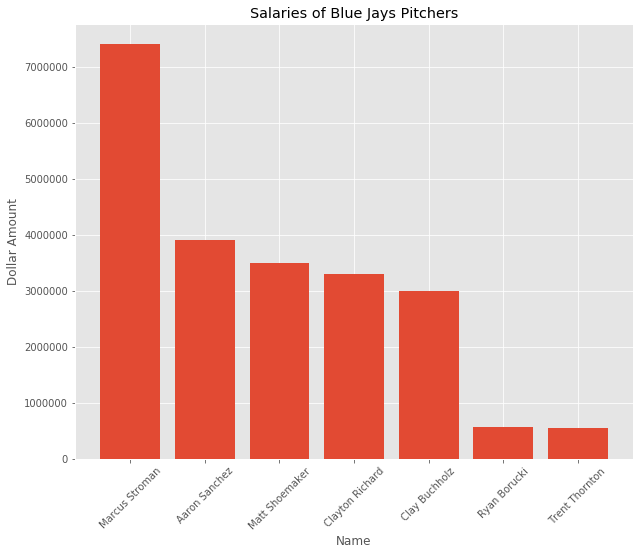

In [87]:
bj_pitcher_salary = df_salaries[(df_salaries.Team=='TOR ') & (df_salaries.POS=='SP')]
plt.figure(figsize=[10,8])
plt.title('Salaries of Blue Jays Pitchers')
plt.xlabel('Name')
plt.ylabel('Dollar Amount')
plt.bar(bj_pitcher_salary.Name, bj_pitcher_salary['Avg Annual'])
plt.xticks(rotation=45)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor");

After sorting the most important features we can conclude that Marcus Stroman is over valued as a starting pitcher compared to someone like Clayton. Aaron Sanchez on the other hand who should be doing better based upon a high ax and vx0 value (release_pos_y is ignored in this case due to how similar all the values are for Blue Jay's pitchers), is not. This can be attributed to him not having a good year, but it wouldn't be a bad decision to keep him and see if there is any improvement in other years.

In [121]:
# Highest positive vx0
df_all.sort_values(by=['vx0'], ascending=[ False]).head(3)

,player_name,release_pos_y,plate_x,ax,vx0,strike_result,inning,Name,Team,Avg Annual
138,Jose Berrios,54.111622,0.109531,-6.997802,9.865613,0.606218,193,Jose Berrios,MIN,620000
55,Max Scherzer,54.670836,0.073283,-7.727817,9.567366,0.708134,209,Max Scherzer,WSH,30000000
111,Bryse Wilson,54.321744,-0.327832,-9.025772,8.764105,0.691358,81,Bryse Wilson,ATL,565000


In [122]:
# Lowest negative vx0
df_all.sort_values(by=['vx0'], ascending=[ True]).head(3)

,player_name,release_pos_y,plate_x,ax,vx0,strike_result,inning,Name,Team,Avg Annual
46,David Price,54.719951,0.445428,14.072684,-9.527456,0.666667,96,David Price,BOS,31000000
48,Andrew Heaney,54.714055,0.145799,10.324481,-9.309647,0.595122,205,Andrew Heaney,LAA,3400000
64,Chris Sale,54.607347,0.073425,11.635448,-8.967461,0.607595,158,Chris Sale,BOS,15000000


In [123]:
# Highest positive ax0
df_all.sort_values(by=['ax'], ascending=[ False]).head(3)

,player_name,release_pos_y,plate_x,ax,vx0,strike_result,inning,Name,Team,Avg Annual
10,Clayton Richard,55.137416,-0.168899,15.429430,-8.660051,0.545455,77,Clayton Richard,TOR,3300000
46,David Price,54.719951,0.445428,14.072684,-9.527456,0.666667,96,David Price,BOS,31000000
78,Eduardo Rodriguez,54.549089,0.345613,13.559576,-6.184603,0.585859,99,Eduardo Rodriguez,BOS,4300000


In [124]:
# Highest positive ax0
df_all.sort_values(by=['ax'], ascending=[ True]).head(3)

,player_name,release_pos_y,plate_x,ax,vx0,strike_result,inning,Name,Team,Avg Annual
60,Jake Arrieta,54.634013,-0.186569,-12.680872,8.745557,0.561798,178,Jake Arrieta,PHI,25000000
63,Zach Davies,54.608860,-0.166304,-12.493595,6.211303,0.555556,171,Zach Davies,MIL,2600000
126,Brandon Woodruff,54.213916,-0.101315,-12.390413,6.409701,0.635071,211,Brandon Woodruff,MIL,561400


In the tables above, we can see a list of pitchers who are much more cost efficient, as well as effective as pitchers compared to some of the players on the Blue Jays roster. Jose Berrios, Andrew Heaney, Eduardo Rodrguez, and Brandon Woodruff are all starting pitchers who fit the description and are a fraction of what Marcus Stroman is being paid. If the Blue Jays can find an opportunity to obtain these players, they will definitely be able to see an improvement with the number of strikes they can get in a game, resulting in more wins.